# PHYS20762 - Project - 

David Phelan  
University of Manchester  
March 2025

This project aims to simulate a driven, damped harmonic oscillator.

In [26]:
# Initilisation
import numpy as np
import matplotlib.pyplot as plt

The below function is an Euler solution to the equation of motion:

$m \frac{d^2 x(t)}{dt^2} + b \frac{d x(t)}{dt} + kx(t) = F(t),$

where the external force, $F(t)$ is $0$ (not driven) and accepting m, b, and k as inputs.

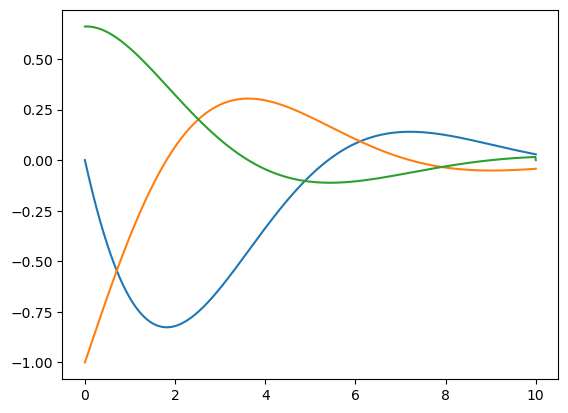

In [ ]:
def Euler_undriven(m, k, b, n, x0, v0, dt):
    # Initialisation
    t = np.linspace(0, n*dt, n+1)
    x = np.zeros(n+1)
    v = np.zeros(n+1)
    a = np.zeros(n+1)
    x[0] = x0
    v[0] = v0
    # Compute initial acceleration
    a[0] = -(k * x[0] + b * v[0]) / m
    # Euler method
    for i in range(n):
        a[i+1] = -(k * x[i+1] + b * v[i+1]) / m
        v[i+1] = v[i] + (-k*x[i] - b*v[i])/m*dt
        x[i+1] = x[i] + v[i]*dt
    return x, v, a, t

params = Euler_undriven(3.03, 1.35, 2, 1000, 0, -1, 0.01)
plt.plot(params[3], params[0])
plt.plot(params[3], params[1])
plt.plot(params[3], params[2])
plt.show()